In [1]:
!pip install transformers
!pip install datasets
!pip install pytorch_metric_learning
!pip install opendatasets
!pip install pydub
!pip install gdown
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 2.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=b109cae0ea63b8bdcf5f68d1701f6798a1b86f4442a1fb7771f72edb2117a204
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
import torch
from transformers import AutoProcessor, Wav2Vec2Model
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from pytorch_metric_learning.losses import ContrastiveLoss
from time import time
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import os
from pydub import AudioSegment
import opendatasets as od
import pandas as pd
import gc
import random
import pickle
import gdown
import json
from nltk import word_tokenize
import string
from zipfile import ZipFile
from torch.nn.functional import cosine_similarity
from tabulate import tabulate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import librosa
import librosa.display
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# url = "https://drive.google.com/file/d/1GkXhLbzHrobM4GaGX80PzRHl-TBPg8h4/view?usp=share_link"
# output = "dataset_part1.zip"
# gdown.download(url, output, quiet=False, fuzzy=True)

# url = "https://drive.google.com/file/d/1n_xxsblXrw5tCVk7ZP6_kRtubjMOuC2l/view?usp=sharing"
# output = "dataset_part2.zip"
# gdown.download(url, output, quiet=False, fuzzy=True)

# url = "https://drive.google.com/file/d/14-Tvd3jvgY2Ge5-cxOsX7Arx6esfUxeN/view?usp=share_link"
# output = "dataset_part3.zip"
# gdown.download(url, output, quiet=False, fuzzy=True)

In [118]:
# url = "https://drive.google.com/file/d/1fId6jAxD5UzObg4zu30GPpcP-P9F7TSL/view?usp=share_link"
# output = "dataset_part4.zip"
# gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1fId6jAxD5UzObg4zu30GPpcP-P9F7TSL
From (redirected): https://drive.google.com/uc?id=1fId6jAxD5UzObg4zu30GPpcP-P9F7TSL&confirm=t&uuid=b282e2d4-b851-450b-a2f6-cb5f91b4fb81
To: /kaggle/working/dataset_part4.zip
100%|██████████| 3.29G/3.29G [00:22<00:00, 143MB/s] 


'dataset_part4.zip'

In [119]:
# with ZipFile('dataset_part4.zip', 'r') as zip_ref:
#     zip_ref.extractall('dataset_part4')

In [4]:
# with ZipFile('dataset_part1.zip', 'r') as zip_ref:
#     zip_ref.extractall('dataset_part1')

In [5]:
# with ZipFile('dataset_part2.zip', 'r') as zip_ref:
#     zip_ref.extractall('dataset_part2')

In [6]:
# with ZipFile('dataset_part3.zip', 'r') as zip_ref:
#     zip_ref.extractall('dataset_part3')

In [120]:
# os.remove('dataset_part1.zip')
# os.remove('dataset_part2.zip')
# os.remove('dataset_part3.zip')
# os.remove('dataset_part4.zip')

In [6]:
# url = "https://drive.google.com/file/d/1MWRTrInoCkdGF-Hj3f8iv0TnzYtGDhkc/view?usp=share_link"
# output = "localized_metadata.json"
# gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1MWRTrInoCkdGF-Hj3f8iv0TnzYtGDhkc
To: /kaggle/working/localized_metadata.json
100%|██████████| 9.73M/9.73M [00:00<00:00, 110MB/s]


'localized_metadata.json'

In [3]:
with open('localized_metadata.json', 'r') as f:
    localized_metdata = json.load(f)
localized_metdata.keys()

dict_keys(['part1', 'part2', 'part3', 'part4', 'part5', 'part6', 'part7', 'part8', 'part9', 'part10'])

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
# Loading data
with open('audio_embeddings_part1.pkl', 'rb') as f:
    audios_dataset = pickle.load(f)
with open('audio_embeddings_part2.pkl', 'rb') as f:
    audios_dataset.extend(pickle.load(f))
with open('audio_embeddings_part3.pkl', 'rb') as f:
    audios_dataset.extend(pickle.load(f))
len(audios_dataset)

16305

In [170]:
# with open('audio_embeddings_part4.pkl', 'rb') as f:
#     audios_dataset_test = pickle.load(f)

In [6]:
with open('text_embeddings.pkl', 'rb') as f:
    text_dataset = pickle.load(f)
len(text_dataset)

16305

In [6]:
gc.collect()

0

In [135]:
audio_processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
audio_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [130]:
test_numbers = 30
part_id = 4
# file_pathes = localized_metdata[f'part{part_id}'][:test_numbers]

In [146]:
# bad_ids = [248, 365, 1460, 1859, 1977, 2953, 3160, 3324, 3345, 3633, 3811, 3877, 4109, 4137, 4678, 4762, 5276, 5340, 5436, 5450, 5494]

In [184]:
bad_ids_part4 = []

In [185]:
audio_embeddings = []
valid_ids = []
part_ids = [4]
for part_id in part_ids:
    for audio_idx in tqdm(range(len(localized_metdata[f'part{part_id}']))):
        if audio_idx % 100 == 0:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
        try:
            file_path = f'dataset_part{part_id}'+'/audios/' + localized_metdata[f'part{part_id}'][audio_idx]['file_path'].split('/')[-1]

            audio_file = AudioSegment.from_file(file_path)
            samples = np.array(audio_file.get_array_of_samples())
            samples = samples.reshape(-1, audio_file.channels)
            samples = samples / np.max(np.abs(samples))
            samples = samples.squeeze()

            audio = torch.from_numpy(samples)
            inputs = audio_processor(audio, sampling_rate=16000, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = audio_model(**inputs)
            last_hidden_states = outputs.last_hidden_state.squeeze(0)
            embeddings = last_hidden_states.mean(dim=0)
            audio_embeddings.append(embeddings)
        except Exception as e:
            print(localized_metdata[f'part{part_id}'][audio_idx]['id'])
            bad_ids_part4.append(localized_metdata[f'part{part_id}'][audio_idx]['id'])
            continue
        valid_ids.append(localized_metdata[f'part{part_id}'][audio_idx]['id'])
        
len(audio_embeddings)

  9%|▉         | 512/5520 [01:22<12:26,  6.71it/s]

17071


 18%|█▊        | 1015/5520 [02:43<12:29,  6.01it/s]

17574


 21%|██        | 1155/5520 [03:06<11:46,  6.18it/s]

17714


 37%|███▋      | 2055/5520 [05:33<09:12,  6.27it/s]

18614


 39%|███▊      | 2135/5520 [05:46<09:09,  6.16it/s]

18694


 40%|███▉      | 2194/5520 [05:56<09:03,  6.12it/s]

18753


 53%|█████▎    | 2935/5520 [07:58<06:51,  6.29it/s]

19494


 54%|█████▍    | 2990/5520 [08:07<06:42,  6.28it/s]

19549


 56%|█████▌    | 3104/5520 [08:25<06:25,  6.27it/s]

19663


 61%|██████    | 3358/5520 [09:06<05:55,  6.08it/s]

19917


 68%|██████▊   | 3755/5520 [10:11<04:37,  6.36it/s]

20314


 79%|███████▉  | 4381/5520 [11:52<02:53,  6.58it/s]

20940


 88%|████████▊ | 4881/5520 [13:13<02:13,  4.78it/s]

21441


100%|██████████| 5520/5520 [14:57<00:00,  6.15it/s]


5507

In [186]:
len(bad_ids_part4)

13

In [187]:
with open('bad_ids_part4.pkl', 'wb') as f:
    pickle.dump(bad_ids_part4, f)

In [188]:
# bad ids = [248, 365, 1460, 1859, 1977, 2953, 3160, 3324, 3345, 3633, 3811, 3877, 4109, 4137, 4678, 4762, 5276, 5340, 5436, 5450, 5494]

In [189]:
print(len(audio_embeddings))

5507


In [190]:
with open('audio_embeddings_part4.pkl', 'wb') as f:
    pickle.dump(audio_embeddings, f)

In [191]:
len(audio_embeddings)

5507

In [192]:
from sentence_transformers import SentenceTransformer

text_model = SentenceTransformer('sentence-transformers/LaBSE').to(device)

In [193]:
sentences = ["This is an example sentence"]
embeddings = text_model.encode(sentences)
print(len(embeddings[0]))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

768


In [14]:
# localized_metdata['part1'][0]

{'id': 1,
 'file_path': 'dataset/part1/audios/audio_1.wav',
 'text': "The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place."}

In [ ]:
# def preprocess_text(text, minimum_length=1, stopword_removal=True, stopwords_domain=[], lower_case=True,
#                        punctuation_removal=True):
    
#     normalized_tokens = word_tokenize(text)

#     if stopword_removal:
#         # Remove stopwords in English and also the given domain stopwords
#         stopwords = [x.lower() for x in nltk.corpus.stopwords.words('english')]
#         domain_stopwords = [x.lower() for x in stopwords_domain]
#         normalized_tokens = [word for word in normalized_tokens if word.lower() not in domain_stopwords + stopwords]

#     if punctuation_removal:
#         # Remove punctuations
#         normalized_tokens = [word for word in normalized_tokens if word not in string.punctuation]

#     if lower_case:
#         # Convert everything to lowercase and filter based on a min length
#         normalized_tokens = [word.lower() for word in normalized_tokens if len(word) > minimum_length]
#     else:
#         normalized_tokens = [word for word in normalized_tokens if len(word) > minimum_length]

#     return normalized_tokens

In [194]:
text_dataset = []
bad_ids_count = 0
parts = [4]
for i in parts:
    part_data = localized_metdata[f'part{i}']
    for item in part_data:
        if item['id'] not in bad_ids_part4:
            text_dataset.append(item['text'])
        else:
            bad_ids_count += 1
print(bad_ids_count)

13


In [195]:
text_dataset[0]

"Parson Weems's George Washington became the symbol of honesty and the father image of the uniting States."

In [196]:
len(text_dataset)

5507

In [197]:
text_embeddings = text_model.encode(text_dataset)

Batches:   0%|          | 0/173 [00:00<?, ?it/s]

In [198]:
len(text_embeddings)

5507

In [199]:
with open('text_embeddings_part4.pkl', 'wb') as f:
    pickle.dump(text_embeddings, f)

# Test

In [9]:
# Loading data
with open('audio_embeddings_part4.pkl', 'rb') as f:
    audios_dataset_test = pickle.load(f)
len(audios_dataset_test)

5507

In [10]:
with open('text_embeddings_part4.pkl', 'rb') as f:
    text_dataset_test = pickle.load(f)
len(text_dataset_test)

5507

In [11]:
class MMDataSet(Dataset):
    def __init__(self, text_embeddings, audio_embeddings):
        self.text_embedings = text_embeddings
        self.audio_embeddings = audio_embeddings
        
    def __len__(self):
        return len(self.text_embedings)

    def __getitem__(self, i):
        return self.text_embedings[i], self.audio_embeddings[i]

In [16]:
test_loader = DataLoader(dataset= MMDataSet(text_dataset_test, audios_dataset_test), batch_size=64, shuffle=True)

In [23]:
test_text_embeddings = []
test_audio_final_embeddings = []
for (text_emb, audio_emb) in tqdm(test_loader):    
    text_emb = text_emb.to(device)
    audio_emb = audio_emb.to(device)
    audio_final_emb = model(audio_emb)
    test_text_embeddings.extend(text_emb)
    test_audio_final_embeddings.extend(audio_final_emb)
print(len(test_text_embeddings))
print(len(test_audio_final_embeddings))

100%|██████████| 87/87 [00:00<00:00, 776.26it/s]

5507
5507


In [31]:
torch.nn.functional.cosine_similarity(test_audio_final_embeddings[0].unsqueeze(0), test_text_embeddings[0].unsqueeze(0)).item()

0.20916886627674103

In [37]:
similarity_arrays = []
for item in tqdm(test_text_embeddings[:100]):
    inside_array = []
    for audio_item in test_audio_final_embeddings[:100]:
        inside_array.append((torch.nn.functional.cosine_similarity(item.unsqueeze(0), audio_item.unsqueeze(0))).item())
    similarity_arrays.append(inside_array)
len(similarity_arrays)

100%|██████████| 100/100 [00:01<00:00, 74.04it/s]


100

In [45]:
similarity_arrays_numpy = np.array(similarity_arrays)
normalized_matrix = similarity_arrays_numpy / similarity_arrays_numpy.sum(axis=1)[:, np.newaxis]

In [55]:
np.sum(normalized_matrix[2])

1.0

In [56]:
normalized_matrix[3][:7]

array([0.01122555, 0.01096408, 0.01137494, 0.00937335, 0.0095107 ,
       0.00882148, 0.00971705])

In [53]:
normalized_matrix[3][:7]

[0.17914706468582153,
 0.17497435212135315,
 0.1815311461687088,
 0.14958816766738892,
 0.15177999436855316,
 0.14078086614608765,
 0.1550731211900711]

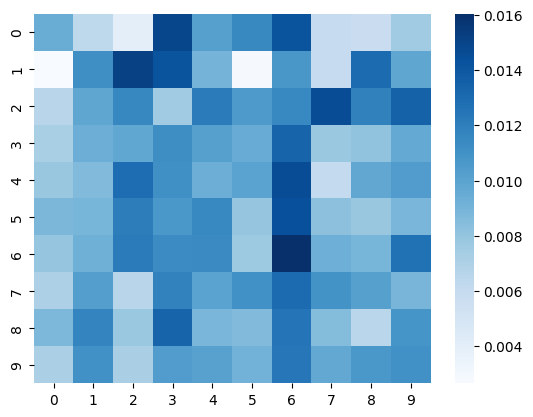

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the confusion matrix

# Plot the confusion matrix using seaborn
sns.heatmap(normalized_matrix[20:30, 20:30], cmap='Blues')
plt.show()

# Main Model

In [14]:
# with open('text_embeddings.pkl', 'rb') as f:
#     text_embeddings = pickle.load(f)

# with open('audio_embeddings.pkl', 'rb') as f:
#     audio_embeddings = pickle.load(f)

In [172]:
text_embeddings = text_dataset
audio_embeddings = audios_dataset

In [173]:
len(audios_dataset)

16305

In [174]:
class MMDataSet(Dataset):
    def __init__(self, text_embeddings, audio_embeddings):
        self.text_embedings = text_embeddings
        self.audio_embeddings = audio_embeddings
        
    def __len__(self):
        return len(self.text_embedings)

    def __getitem__(self, i):
        return self.text_embedings[i], self.audio_embeddings[i]

In [175]:
text_embedding_train, text_embedding_test, audio_embedding_train, audio_embedding_test = train_test_split(text_embeddings, audio_embeddings, test_size=0.2, random_state=42)
text_embedding_val, text_embedding_test, audio_embedding_val, audio_embedding_test = train_test_split(text_embedding_test, audio_embedding_test, test_size=0.5, random_state=42)

train_loader = DataLoader(dataset= MMDataSet(text_embedding_train, audio_embedding_train), batch_size=64, shuffle=True)
val_loader = DataLoader(dataset= MMDataSet(text_embedding_val, audio_embedding_val), batch_size=64, shuffle=False)
test_loader = DataLoader(dataset= MMDataSet(text_embedding_test, audio_embedding_test), batch_size=64, shuffle=False)

In [200]:
# test_loader2 = DataLoader(dataset= MMDataSet(text_embeddings, audio_embeddings), batch_size=64, shuffle=True)

In [26]:
class JointNN(nn.Module):
    def __init__(self, in_features):
        super(JointNN, self).__init__()
#         self.text_seq = nn.Sequential(
#             nn.Linear(in_features, 576),
#             nn.BatchNorm1d(576),
#             nn.LeakyReLU(),
#             nn.Dropout(p=0.15),
#             nn.Linear(576, 384),
#             nn.BatchNorm1d(384),
#             nn.LeakyReLU(),
#             nn.Dropout(p=0.1),
#             nn.Linear(384, 576),
#             nn.LeakyReLU(),
#             nn.Linear(576, in_features),
#         )
        self.audio_seq = nn.Sequential(
            nn.Linear(in_features, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features),
        )
    
    def forward(self, x_audio):
        x = self.audio_seq(x_audio)
        return x

#     def forward(self, x_text, x_audio):
#         x1 = self.text_seq(x_text)
#         x2 = self.audio_seq(x_audio)
#         return x1, x2

In [177]:
model = JointNN(768).to(device)
criterion = nn.MSELoss()
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [178]:
def eval_epoch(model: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader, test_mode=False):
    eval_loss = 0
    i = 0 

    with torch.no_grad(), tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (text_emb, audio_emb) in pbar:
            text_emb = text_emb.to(device)
            audio_emb = audio_emb.to(device)
            audio_final_emb = model(audio_emb)               

            loss = criterion(text_emb, audio_final_emb)

            eval_loss += loss.item()

            discription = 'Validation' if not test_mode else 'Test'
            pbar.set_description(f'{discription} Loss: {loss.item():.4f}')
    return eval_loss

In [179]:
num_epochs = 15

train_loss_arr, val_loss_arr = [], []
for epoch in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    start_time = time()

    train_loss, val_loss = 0, 0
    epoch_all = 0
    epoch_true = 0
    i = 0

    model.train()
    
    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (text_emb, audio_emb) in pbar:    
            text_emb = text_emb.to(device)
            audio_emb = audio_emb.to(device)
            
            audio_final_emb = model(audio_emb)               
            loss = criterion(text_emb, audio_final_emb)
            
            
            train_loss += loss.item()

            pbar.set_description(f'Loss: {loss.item():.4f}')

            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

  
    model.eval()
    
    val_loss = eval_epoch(model, criterion, val_loader)
    
#     train_loss /= len(train_loader.dataset)
#     val_loss /= len(test_loader.dataset)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    
    end_time = time()
    
    print(f'Epoch {epoch + 1} finished in {end_time - start_time:.2f}s')

    print(f"[Epoch {epoch + 1}]\t"
        f"Train Loss: {train_loss:.6f}\t"
        f"Validation Loss: {val_loss:.6f}")

Validation Loss: 0.0060: 100%|██████████| 26/26 [00:00<00:00, 373.94it/s]


Epoch 1 finished in 1.12s
[Epoch 1]	Train Loss: 3.354320	Validation Loss: 0.169794


Validation Loss: 0.0031: 100%|██████████| 26/26 [00:00<00:00, 293.73it/s]


Epoch 2 finished in 1.02s
[Epoch 2]	Train Loss: 1.394364	Validation Loss: 0.086193


Validation Loss: 0.0022: 100%|██████████| 26/26 [00:00<00:00, 314.63it/s]


Epoch 3 finished in 1.01s
[Epoch 3]	Train Loss: 0.808943	Validation Loss: 0.059441


Validation Loss: 0.0019: 100%|██████████| 26/26 [00:00<00:00, 307.91it/s]


Epoch 4 finished in 1.01s
[Epoch 4]	Train Loss: 0.559199	Validation Loss: 0.049036


Validation Loss: 0.0017: 100%|██████████| 26/26 [00:00<00:00, 289.07it/s]


Epoch 5 finished in 1.01s
[Epoch 5]	Train Loss: 0.448359	Validation Loss: 0.044970


Validation Loss: 0.0016: 100%|██████████| 26/26 [00:00<00:00, 315.32it/s]


Epoch 6 finished in 1.01s
[Epoch 6]	Train Loss: 0.391655	Validation Loss: 0.042414


Validation Loss: 0.0015: 100%|██████████| 26/26 [00:00<00:00, 323.98it/s]


Epoch 7 finished in 1.02s
[Epoch 7]	Train Loss: 0.357421	Validation Loss: 0.040360


Validation Loss: 0.0015: 100%|██████████| 26/26 [00:00<00:00, 300.15it/s]


Epoch 8 finished in 1.04s
[Epoch 8]	Train Loss: 0.333019	Validation Loss: 0.038508


Validation Loss: 0.0014: 100%|██████████| 26/26 [00:00<00:00, 338.31it/s]


Epoch 9 finished in 1.05s
[Epoch 9]	Train Loss: 0.313285	Validation Loss: 0.036739


Validation Loss: 0.0014: 100%|██████████| 26/26 [00:00<00:00, 216.79it/s]


Epoch 10 finished in 1.12s
[Epoch 10]	Train Loss: 0.296724	Validation Loss: 0.035061


Validation Loss: 0.0013: 100%|██████████| 26/26 [00:00<00:00, 368.29it/s]


Epoch 11 finished in 1.14s
[Epoch 11]	Train Loss: 0.282098	Validation Loss: 0.033674


Validation Loss: 0.0013: 100%|██████████| 26/26 [00:00<00:00, 233.15it/s]


Epoch 12 finished in 1.05s
[Epoch 12]	Train Loss: 0.270488	Validation Loss: 0.032578


Validation Loss: 0.0012: 100%|██████████| 26/26 [00:00<00:00, 371.53it/s]


Epoch 13 finished in 1.05s
[Epoch 13]	Train Loss: 0.261232	Validation Loss: 0.031824


Validation Loss: 0.0012: 100%|██████████| 26/26 [00:00<00:00, 300.03it/s]


Epoch 14 finished in 1.03s
[Epoch 14]	Train Loss: 0.254324	Validation Loss: 0.031232


Validation Loss: 0.0012: 100%|██████████| 26/26 [00:00<00:00, 299.27it/s]


Epoch 15 finished in 1.12s
[Epoch 15]	Train Loss: 0.249166	Validation Loss: 0.030834


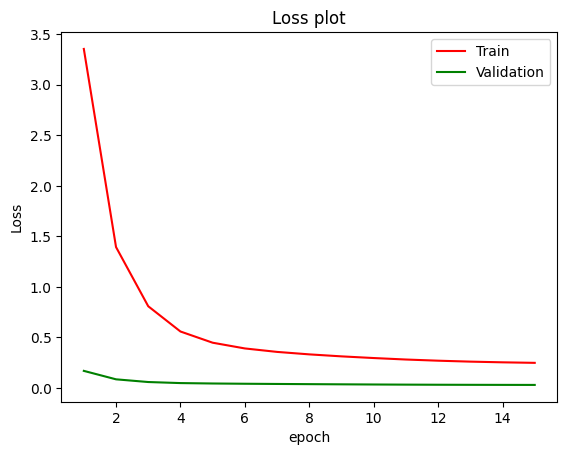

In [180]:
ls_epoch = [_ + 1 for _ in range(num_epochs)]
plt.plot(ls_epoch, train_loss_arr, color='r', label='Train')
plt.plot(ls_epoch, val_loss_arr, color='g', label='Validation')
plt.title('Loss plot')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [201]:
test_text_embeddings = []
test_audio_embeddings = []
for (text_emb, audio_emb) in tqdm(test_loader):    
    text_emb = text_emb.to(device)
    audio_emb = audio_emb.to(device)
    audio_final_emb = model(audio_emb)
    test_text_embeddings.append(text_emb)
    test_audio_embeddings.append(audio_final_emb)

100%|██████████| 87/87 [00:00<00:00, 733.52it/s]


In [202]:
test_text_embeddings2 = torch.cat(test_text_embeddings, dim=0)[:100]
similarity_arrays = []
i = 0
j = 0
for item in tqdm(test_text_embeddings2):
    inside_array = []
    for j in range(len(test_text_embeddings2)):
        inside_array.append(torch.nn.functional.cosine_similarity(item.unsqueeze(0), test_text_embeddings2[j].unsqueeze(0)).item())
    similarity_arrays.append(inside_array)
len(similarity_arrays)

100%|██████████| 100/100 [00:01<00:00, 86.05it/s]


100

In [206]:
similarity_arrays[4][:7]

[0.15576550364494324,
 -0.05074957013130188,
 0.08943834155797958,
 0.05855824798345566,
 1.0,
 0.11039011180400848,
 0.1639634370803833]

In [26]:
PATH = "multimodal_model.pt"
torch.save(model, PATH)

In [15]:
# Load
PATH = "multimodal_model.pt"
model = torch.load(PATH)
model.eval()
model = model.to(device)

In [28]:
class SimilarityModel:
    def __init__(self, path_to_multimodal_model, sampling_rate=16000, threshold=0.5):
      self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      self.audio_processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
      self.audio_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(self.device)
      self.text_model = SentenceTransformer('sentence-transformers/LaBSE').to(self.device)
      self.threshold = threshold
      self.nn_model = torch.load(path_to_multimodal_model)
      self.nn_model.eval()
      self.nn_model = self.nn_model.to(self.device)
      self.sampling_rate = sampling_rate

    def cosine_similarity(self, embedding1, embedding2):
      dim = 1
      embedding1 = F.normalize(embedding1, p=2, dim=dim)
      embedding2 = F.normalize(embedding2, p=2, dim=dim)

      dot_product = torch.sum(embedding1 * embedding2, dim=dim)

      magnitude1 = torch.norm(embedding1, p=2, dim=dim)
      magnitude2 = torch.norm(embedding2, p=2, dim=dim)

      cosine_sim = dot_product / (magnitude1 * magnitude2)

      return cosine_sim

    def predict(self, audios, texts, threshold=None, is_query=False):
      audio_embs = []
    
      gc.collect()
      torch.cuda.empty_cache()
      torch.cuda.ipc_collect()
        
      for audio in tqdm(audios):
        inputs = self.audio_processor(audio, sampling_rate=self.sampling_rate, return_tensors="pt", padding=True).to(device)
        outputs = self.audio_model(**inputs)
        last_hidden_states = outputs.last_hidden_state.squeeze(0)
        audio_embedding = last_hidden_states.mean(dim=0)
        audio_embs.append(audio_embedding)

      text_embs = text_model.encode(texts)
    
      if is_query:
        text_embs = list(text_embs)
        item = text_embs[0]
        for i in range(len(audios) - 1):
          text_embs.append(item.copy())
        text_embs = np.array(text_embs)


      audio_embedding = torch.stack(audio_embs)
      text_embedding = torch.from_numpy(text_embs)
      text_embedding = text_embedding.to(self.device)
      audio_embedding = audio_embedding.to(self.device)

      audio_final_emb = self.nn_model(audio_embedding)
      cosine_similarity = self.cosine_similarity(text_embedding, audio_final_emb)
      print(cosine_similarity)

      final_threshold = threshold if threshold else self.threshold

      return (cosine_similarity >= final_threshold).int()

    def retrieve_relevant_audios(self, audios, query, threshold=None):
      return self.predict(audios, [query], is_query=True, threshold=threshold)

In [29]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [35]:
PATH = "multimodal_model.pt"

final_model = SimilarityModel(PATH)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
dataset = load_dataset("asapp/slue", "voxpopuli")
selected_dataset = dataset['test'].shuffle(0).select(range(20))
texts = selected_dataset['normalized_text']
audios = [x["array"] for x in selected_dataset['audio']]

  0%|          | 0/3 [00:00<?, ?it/s]

In [44]:
texts[1]

'another thing we can have simplified audit as well introducing more simplified approach and removing unnecessary requirements.'

In [47]:
final_model.predict(audios[5:8], texts[5:8])

100%|██████████| 3/3 [00:00<00:00, 25.98it/s]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([0.0818, 0.1976, 0.1267], device='cuda:0', grad_fn=<DivBackward0>)


tensor([0, 0, 0], device='cuda:0', dtype=torch.int32)

In [41]:
total_num = 5
text_embedding = torch.from_numpy(text_embedding_test)
text_embedding = text_embedding[0].to(device)
audio_embeddings = torch.stack([audio_embedding_test[i].to(device) for i in range(total_num)])
cosine_similarity_list = []

for i in range(total_num):
    audio_final_emb = final_model.nn_model(audio_embeddings[i].unsqueeze(0))
    cosine_similarity = final_model.cosine_similarity(text_embedding.unsqueeze(0), audio_final_emb)
    cosine_similarity_list.append(cosine_similarity.item())
cosine_similarity_list

[0.4066867530345917,
 0.4066867530345917,
 0.4066867530345917,
 0.4066867530345917,
 0.4144911766052246]

In [96]:
final_model.retrieve_relevant_audios(audios[10:14], texts[12])

100%|██████████| 4/4 [00:00<00:00, 21.03it/s]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([0.2502, 0.2396, 0.2482, 0.2435], device='cuda:0',
       grad_fn=<DivBackward0>)


tensor([0, 0, 0, 0], device='cuda:0', dtype=torch.int32)

In [97]:
PATH = "final_relevant_model.pt"

# Save
torch.save(final_model, PATH)

In [100]:
# Load
PATH = "final_relevant_model.pt"
final_model = torch.load(PATH)

# Model Evaluation Preperation

In [5]:
with open('bad_ids_part4.pkl', 'rb') as f:
    bad_test_ids = pickle.load(f)
bad_test_ids

[17071,
 17574,
 17714,
 18614,
 18694,
 18753,
 19494,
 19549,
 19663,
 19917,
 20314,
 20940,
 21441]

In [6]:
# Loading data
with open('audio_embeddings_part4.pkl', 'rb') as f:
    audios_dataset_test = pickle.load(f)
len(audios_dataset_test)

5507

In [7]:
with open('text_embeddings_part4.pkl', 'rb') as f:
    text_dataset_test = pickle.load(f)
len(text_dataset_test)

5507

In [10]:
all_ids = [item['id'] for item in localized_metdata['part4']]
len(all_ids)

5520

In [11]:
valid_test_ids = set(all_ids) - set(bad_test_ids)

In [12]:
len(valid_test_ids)

5507

In [19]:
valid_test_ids = list(valid_test_ids)
valid_test_ids[:10]

[16561, 16562, 16563, 16564, 16565, 16566, 16567, 16568, 16569, 16570]

In [20]:
if valid_test_ids == sorted(valid_test_ids):
    print("The list is sorted.")
else:
    print("The list is not sorted.")

The list is sorted.


In [22]:
number_of_candidates_per_sample = 5
validation_metadata = []

for index, _id in enumerate(valid_test_ids):
    candidate_indexes = random.sample([i for i, x in enumerate(valid_test_ids) if x != _id], number_of_candidates_per_sample - 1)
    candidate_indexes += [index]
    candidates = [valid_test_ids[i] for i in candidate_indexes]
    data = {'index': index, 'id':_id, 'candidate_indexes':candidate_indexes, 'candidates_ids': candidates}
    validation_metadata.append(data)
len(validation_metadata)

5507

In [23]:
validation_metadata[0]

{'index': 0,
 'id': 16561,
 'candidate_indexes': [3164, 4925, 1720, 1669, 0],
 'candidates_ids': [19734, 21499, 18284, 18233, 16561]}

In [24]:
with open('test_meta_data.pkl', 'wb') as f:
    pickle.dump(validation_metadata, f)

# Evaluate Model

In [27]:
# Load
PATH = "multimodal_model.pt"
model = torch.load(PATH)
model.eval()
model = model.to(device)

In [56]:
class TestDataset(Dataset):
    def __init__(self, audios_dataset, text_dataset, metadata):
        self.audios_data = audios_dataset
        self.text_data = text_dataset
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        sample = self.metadata[index]
        candidates_indexes = sample['candidate_indexes']
        text_embedding = self.text_data[index]
        audio_embeddings = [self.audios_data[i] for i in sample['candidate_indexes']]
        label_index = 4
        audio_embeddings = torch.stack(audio_embeddings)

        return text_embedding, audio_embeddings, label_index

In [57]:
test_dataset = TestDataset(audios_dataset_test, text_dataset_test, validation_metadata)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [58]:
def compute_cosine_similarity(embedding1: torch.Tensor, embedding2: torch.Tensor) -> float:
    similarity = cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()
    return similarity

In [61]:
total_hits_1 = 0
for text_embedding, candidates, label in test_loader:
    label = label[0]
    text_embedding = text_embedding[0].to(device)
    candidates = candidates[0]
    candidates = candidates.to(device)
    label = label.to(device)
    print(text_embedding.shape)
    print(candidates.shape)

    audio_final_embs = model(candidates)
    print(audio_final_embs.shape)
    print(audio_final_embs[0].shape)
    text_candidate_cosine_similarities = [compute_cosine_similarity(text_embedding, item) for item in audio_final_embs]
    print(label.item())
    print(text_candidate_cosine_similarities)
    break

torch.Size([768])
torch.Size([5, 768])
torch.Size([5, 768])
torch.Size([768])
4
[0.14302149415016174, 0.21190670132637024, 0.17940135300159454, 0.15339872241020203, 0.20166808366775513]


In [44]:
def cosine_similarity(embedding1, embedding2):
    dim = 1
    embedding1 = F.normalize(embedding1, p=2, dim=dim)
    embedding2 = F.normalize(embedding2, p=2, dim=dim)

    dot_product = torch.sum(embedding1 * embedding2, dim=dim)

    magnitude1 = torch.norm(embedding1, p=2, dim=dim)
    magnitude2 = torch.norm(embedding2, p=2, dim=dim)

    cosine_sim = dot_product / (magnitude1 * magnitude2)

    return cosine_sim

In [79]:
def evaluate(model, dataloader, threshold=0.5):
    total_hits_1 = 0
    total_mrr = 0
    total_instances = 0
    total_labels = []
    total_predictions = []
    number_of_golden_predictions = 0

    with torch.no_grad():
        for text_embedding, candidates, label in tqdm(dataloader):
            label = label[0]
            text_embedding = text_embedding[0].to(device)
            candidates = candidates[0]
            candidates = candidates.to(device)
            label = label.to(device)
            
            audio_final_embs = model(candidates)
            
            text_candidate_cosine_similarities = [compute_cosine_similarity(text_embedding, item) for item in audio_final_embs]
            predicted_idx = np.argmax(text_candidate_cosine_similarities)
            
            label_similarity = text_candidate_cosine_similarities[label.item()]

            # Compute Hits@1
            if predicted_idx == label.item():   
                total_hits_1 += 1

            # Compute MRR
            label_rank = sum([1 for x in text_candidate_cosine_similarities if x > text_candidate_cosine_similarities[label.item()]])
            reciprocal_rank = 1 / (label_rank + 1)
            total_mrr += reciprocal_rank

            # Record predictions and labels
            predictions = [0 if sim < threshold else 1 for sim in text_candidate_cosine_similarities]
            total_labels.extend([0 if i != label.item() else 1 for i in range(len(text_candidate_cosine_similarities))])
            total_predictions.extend(predictions)
            if label_similarity >= threshold:
                number_of_golden_predictions += 1

            total_instances += 1

    # Compute average metrics over all instances
    avg_hits_1 = total_hits_1 / total_instances
    avg_mrr = total_mrr / total_instances
    precision = precision_score(total_labels, total_predictions, average='macro')
    recall = recall_score(total_labels, total_predictions, average='macro')
    f1 = f1_score(total_labels, total_predictions, average='macro')
    precision_micro = precision_score(total_labels, total_predictions, average='micro')
    recall_micro = recall_score(total_labels, total_predictions, average='micro')
    f1_micro = f1_score(total_labels, total_predictions, average='micro')
    accuracy = accuracy_score(total_labels, total_predictions)
    golden_prediction_accuracy = number_of_golden_predictions / total_instances

    return {
        'Hits@1': avg_hits_1,
        'MRR': avg_mrr,
        'Macro Precision': precision,
        'Macro Recall': recall,
        'Macro F1': f1,
        'Micro Precision': precision_micro,
        'Micro Recall': recall_micro,
        'Micro F1': f1_micro,
        'Accuracy': accuracy,
        'Golden Accuracy': golden_prediction_accuracy,
    }

In [80]:
results = evaluate(model, test_loader, threshold=0.2)
table = []
for i in range(len(results)):
    table.append([list(results.keys())[i], list(results.values())[i]])
print(tabulate(table, ['Metrics', 'Values'], tablefmt="grid"))

100%|██████████| 5507/5507 [00:07<00:00, 692.40it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.19448  |
+-----------------+----------+
| MRR             | 0.454633 |
+-----------------+----------+
| Macro Precision | 0.504468 |
+-----------------+----------+
| Macro Recall    | 0.503246 |
+-----------------+----------+
| Macro F1        | 0.499851 |
+-----------------+----------+
| Micro Precision | 0.721518 |
+-----------------+----------+
| Micro Recall    | 0.721518 |
+-----------------+----------+
| Micro F1        | 0.721518 |
+-----------------+----------+
| Accuracy        | 0.721518 |
+-----------------+----------+
| Golden Accuracy | 0.139459 |
+-----------------+----------+


# Image Approach

In [28]:
from IPython.display import Audio

part_id = 1
audio_idx = 10
audio_file = f'dataset_part{part_id}'+'/audios/' + localized_metdata[f'part{part_id}'][audio_idx]['file_path'].split('/')[-1]
Audio(audio_file)

In [29]:
localized_metdata[f'part{part_id}'][audio_idx]

{'id': 11,
 'file_path': 'dataset/part1/audios/audio_11.wav',
 'text': "It urged that the city `` take steps to remedy '' this problem."}

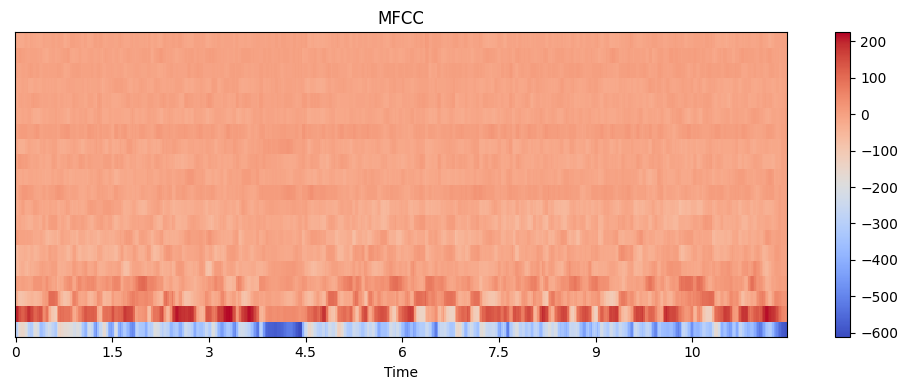

In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load audio file
y, sr = librosa.load(audio_file)

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr)

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

# plt.savefig('path/to/output/file.png')

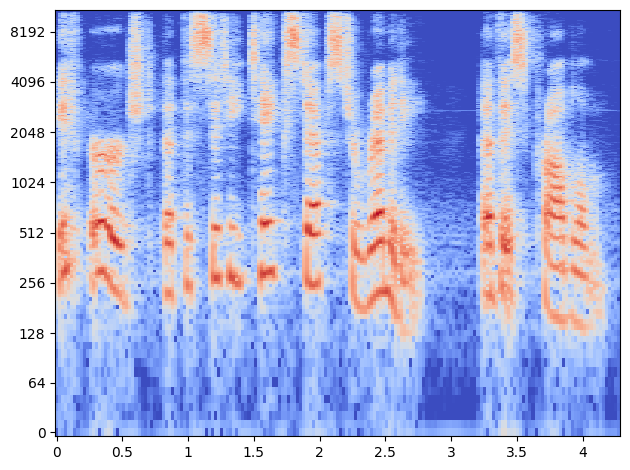

In [34]:
# Load audio file
y, sr = librosa.load(audio_file)

# Compute spectrogram
spec = librosa.stft(y)

# Convert to dB scale
spec_db = librosa.amplitude_to_db(abs(spec))

# Plot spectrogram
# plt.figure(figsize=(10, 4))
librosa.display.specshow(spec_db, x_axis='time', y_axis='log')
# plt.colorbar()
# plt.title('Spectrogram')
# plt.axis('off')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

plt.savefig('sample_image.png', bbox_inches='tight', pad_inches=0)

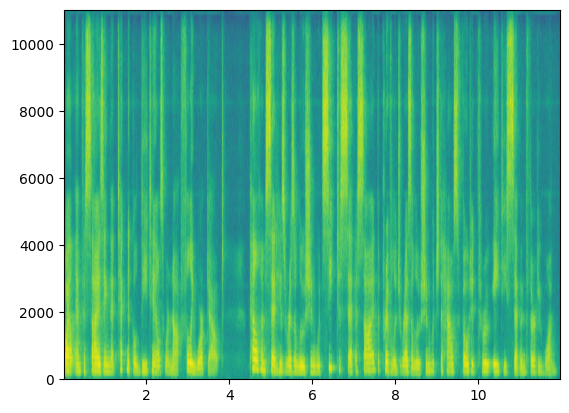

In [13]:
from scipy.io import wavfile

sample_rate, samples = wavfile.read(audio_file)
plt.specgram(samples, Fs=sample_rate)
plt.show()


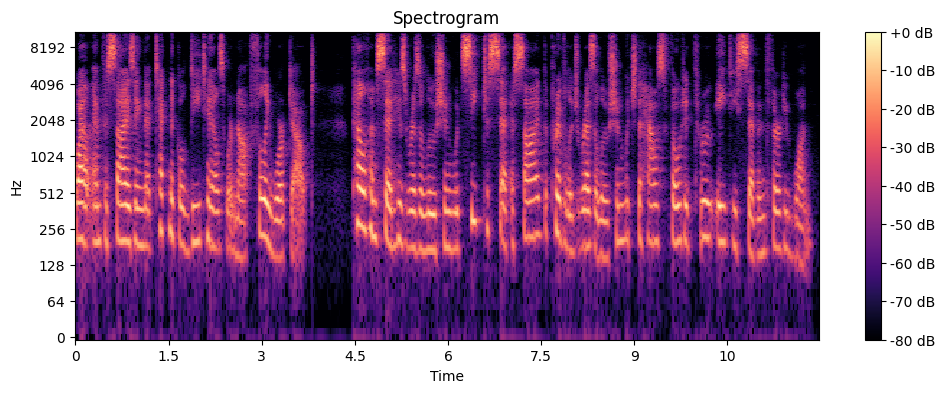

In [14]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
y, sr = librosa.load(audio_file)

# Compute the spectrogram
D = librosa.stft(y)
spectrogram = librosa.amplitude_to_db(abs(D), ref=np.max)

# Display the spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()


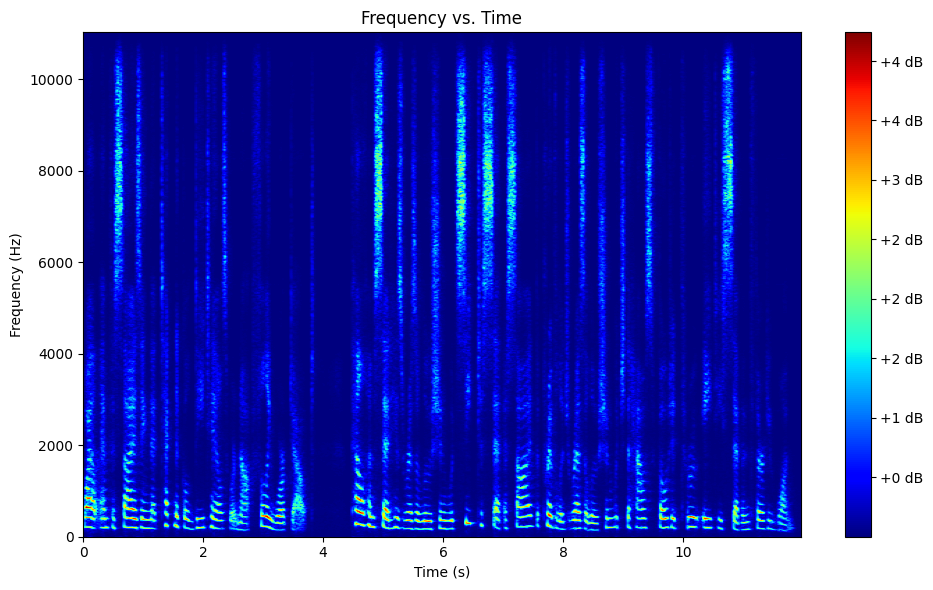

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

# Load the audio file
sample_rate, samples = wav.read(audio_file)

# Compute the Short-Time Fourier Transform (STFT)
n_fft = 2048
hop_length = 512
stft = np.abs(librosa.stft(samples, n_fft=n_fft, hop_length=hop_length))

# Convert to frequencies
freqs = librosa.core.fft_frequencies(sr=sample_rate, n_fft=n_fft)

# Convert to times
times = librosa.core.frames_to_time(np.arange(stft.shape[1]), sr=sample_rate, hop_length=hop_length)

# Plot the frequency vs. time graph
plt.figure(figsize=(10, 6))
plt.imshow(np.log1p(stft), aspect='auto', origin='lower', cmap='jet', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency vs. Time')
plt.tight_layout()
plt.show()


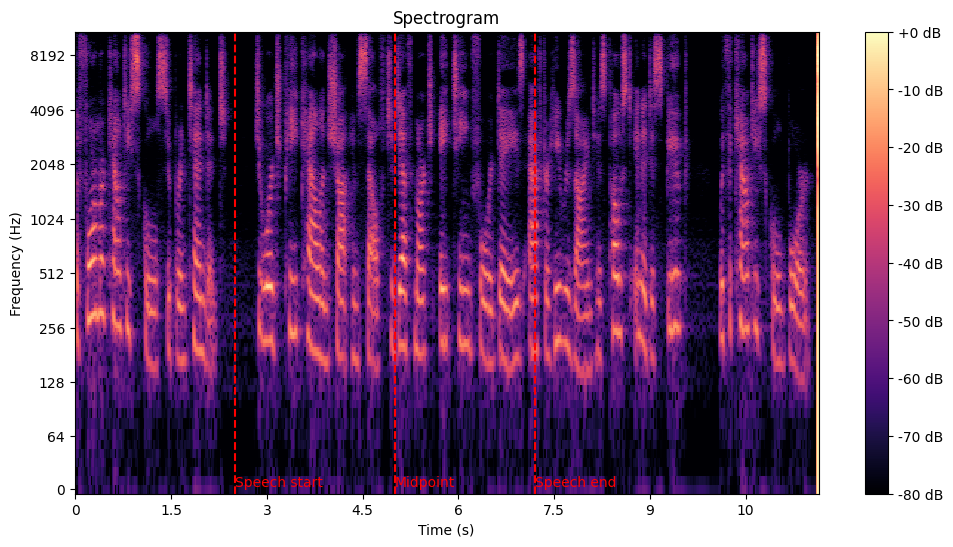

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import librosa
import librosa.display

# Load the audio file
audio_path = audio_file
sample_rate, samples = wav.read(audio_path)

# Compute the spectrogram
n_fft = 2048
hop_length = 512
spectrogram = np.abs(librosa.stft(samples, n_fft=n_fft, hop_length=hop_length))
spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

# Get the timestamps for each frame
timestamps = librosa.frames_to_time(np.arange(spectrogram.shape[1]), sr=sample_rate, hop_length=hop_length)

# Plot the spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(spectrogram_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

# Add additional annotations or overlays
# For example, you can draw vertical lines to mark specific timestamps
timestamps_of_interest = [2.5, 5.0, 7.2]  # Adjust these timestamps as needed
for timestamp in timestamps_of_interest:
    plt.axvline(x=timestamp, color='r', linestyle='--')

# You can also add text annotations
text_annotations = ['Speech start', 'Midpoint', 'Speech end']  # Adjust the annotations as needed
for timestamp, annotation in zip(timestamps_of_interest, text_annotations):
    plt.text(timestamp, 0, annotation, color='r', verticalalignment='bottom')

plt.show()


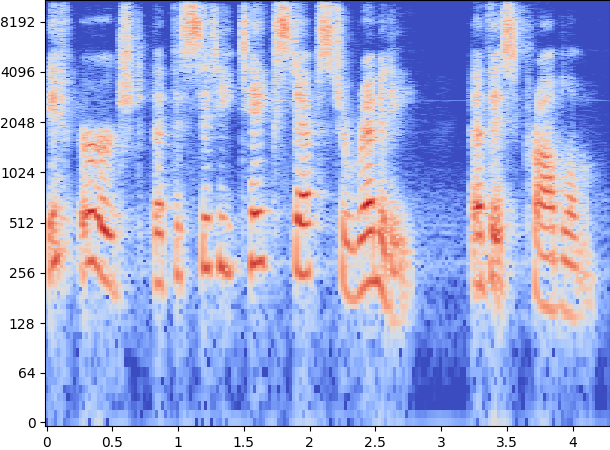

In [36]:
from IPython.display import Image
Image(filename='sample_image.png')

In [8]:
def generate_images(part_id, start_index=None):
    valid_ids = []
    bad_ids = []
    os.makedirs(f'dataset_part{part_id}_images', exist_ok=True)
    
    first_index = localized_metdata[f'part{part_id}'][0]['id']
    if start_index is None:
        start_index = first_index
    
    for audio_idx in tqdm(range(start_index - first_index ,len(localized_metdata[f'part{part_id}']))):
            if audio_idx % 100 == 0:
                gc.collect()
                torch.cuda.empty_cache()
                torch.cuda.ipc_collect()
            try:
                file_path = f'dataset_part{part_id}'+'/audios/' + localized_metdata[f'part{part_id}'][audio_idx]['file_path'].split('/')[-1]

                y, sr = librosa.load(file_path)
                spec = librosa.stft(y)
                spec_db = librosa.amplitude_to_db(abs(spec))
                
                plt.clf()
                librosa.display.specshow(spec_db, x_axis='time', y_axis='log')
                plt.xlabel('')
                plt.ylabel('')
                plt.tight_layout()

                _id = localized_metdata[f'part{part_id}'][audio_idx]['id']
                saved_path = f'dataset_part{part_id}_images/spec_{_id}.png'
                plt.savefig(saved_path, bbox_inches='tight', pad_inches=0)

            except Exception as e:
                print(localized_metdata[f'part{part_id}'][audio_idx]['id'])
                bad_ids.append(localized_metdata[f'part{part_id}'][audio_idx]['id'])
                continue
            valid_ids.append(localized_metdata[f'part{part_id}'][audio_idx]['id'])
    return valid_ids, bad_ids

In [ ]:
generate_images(1)

In [ ]:
valid_ids , bad_ids = generate_images(2, 7828)

In [5]:
part_id = 2
a = os.listdir(f'dataset_part{part_id}_images')
largest_number = max(int(filename.split('_')[1].split('.')[0]) for filename in a)

print(largest_number)

7828


In [7]:
all_valid_image_ids = {}
part_ids = {1,2}
for part_id in part_ids:
    ids = list(int(filename.split('_')[1].split('.')[0]) for filename in os.listdir(f'dataset_part{part_id}_images'))
    all_valid_image_ids[part_id] = ids

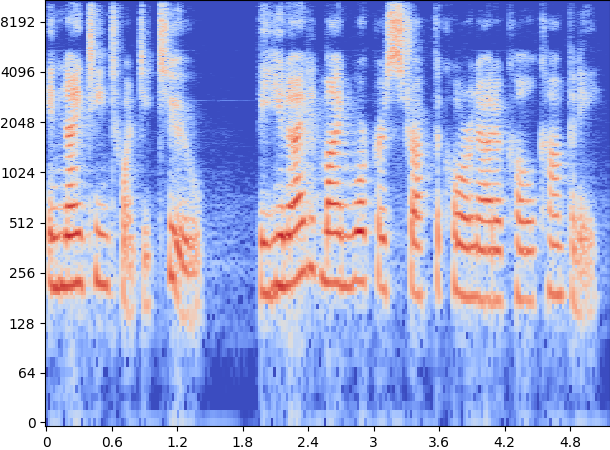

In [8]:
from IPython.display import Image
Image(filename=f'/kaggle/working/dataset_part1_images/spec_3666.png')

# Image Based Model

In [25]:
import torchvision.models as models

vision_model = models.efficientnet_b7(pretrained=True)
vision_model.cuda()
_ = vision_model.eval()

In [26]:
import torchvision.transforms.functional as F
from PIL import Image
import cv2

image = cv2.imread("/kaggle/working/dataset_part1_images/spec_60.png")
# image = Image.open('/kaggle/working/dataset_part1_images/spec_3666.png')
# image = F.to_tensor(image)
print(image.shape)
image_tensor = torch.from_numpy(image)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.permute(0, 3, 1, 2)
image_tensor = image_tensor.to(device)
image_tensor = image_tensor.float()
# Generate the image embedding
with torch.no_grad():
    output = vision_model(image_tensor)
    embedding = output[0].cpu()
embedding.shape

(450, 609, 3)


torch.Size([1000])

In [29]:
part_id = 2
image_embeddings = []
for _id in tqdm(all_valid_image_ids[part_id]):
    image = cv2.imread(f"/kaggle/working/dataset_part{part_id}_images/spec_{_id}.png")
    image_tensor = torch.from_numpy(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.permute(0, 3, 1, 2)
    image_tensor = image_tensor.to(device)
    image_tensor = image_tensor.float()
    with torch.no_grad():
        output = vision_model(image_tensor)
        embedding = output[0].cpu()
        image_embeddings.append(embedding)

100%|██████████| 5340/5340 [05:49<00:00, 15.26it/s]


In [30]:
with open(f'image_embeddings_part{part_id}.pkl', 'wb') as f:
    pickle.dump(image_embeddings, f)

In [49]:
with open('image_embeddings_part1.pkl', 'rb') as f:
    image_embeddings = pickle.load(f)
with open('image_embeddings_part2.pkl', 'rb') as f:
    image_embeddings.extend(pickle.load(f))
len(image_embeddings)

10860

In [10]:
localized_metdata['part1'][0]

{'id': 1,
 'file_path': 'dataset/part1/audios/audio_1.wav',
 'text': "The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place."}

In [11]:
# Loading data
with open('bad_ids.pkl', 'rb') as f:
    bad_ids = pickle.load(f)
len(bad_ids)

255

In [20]:
all_valid_images_ids_list = []
for key in all_valid_image_ids:
    all_valid_images_ids_list.extend(all_valid_image_ids[key])
len(all_valid_images_ids_list)

10860

In [31]:
all_valid_ids = set(all_valid_images_ids_list) - set(bad_ids)
len(all_valid_ids)

10822

In [42]:
meta_data_valid_image_items[10000]

{'id': 10393,
 'file_path': 'dataset/part2/audios/audio_10393.wav',
 'text': 'If we are born of God we grow in ( not into , but in ) grace.'}

In [44]:
meta_data_valid_image_items = []
for key in [1, 2]:
    for item in localized_metdata[f'part{key}']:
        if item['id'] in all_valid_ids:
            meta_data_valid_image_items.append(item)
print(len(meta_data_valid_image_items))

10822


In [45]:
__ids = [_['id'] for _ in meta_data_valid_image_items]
ss = all_valid_ids - set(__ids)
len(ss)

0

In [46]:
len(set(__ids) - set(bad_ids))

10822

In [47]:
# Loading data
with open('audio_embeddings_part1.pkl', 'rb') as f:
    audios_dataset = pickle.load(f)
with open('audio_embeddings_part2.pkl', 'rb') as f:
    audios_dataset.extend(pickle.load(f))
len(audios_dataset)

10822

In [48]:
with open('text_embeddings.pkl', 'rb') as f:
    text_dataset = pickle.load(f)
len(text_dataset)

16305

In [50]:
selected_audio_embeddings = []
selected_text_embeddings = []
selected_image_embeddings = []
image_metadata = {}
c = 0
for i, image_id in tqdm(enumerate(all_valid_images_ids_list)):
    if image_id in __ids:
        selected_audio_embeddings.append(audios_dataset[c])
        selected_text_embeddings.append(text_dataset[c])
        selected_image_embeddings.append(image_embeddings[i])
        c += 1
print(len(selected_audio_embeddings))
print(len(selected_text_embeddings))
print(len(selected_image_embeddings))

10860it [00:00, 19146.96it/s]

10822
10822
10822


# Train new model

In [2]:
from IPython.display import FileLink
FileLink(r'image_model_dataset.pkl')

/kaggle/working/image_model_dataset.pkl

In [112]:
dataset = (selected_audio_embeddings, selected_text_embeddings, selected_image_embeddings)
with open(f'image_model_dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [212]:
with open(f'image_model_dataset.pkl', 'rb') as f:
    (selected_audio_embeddings, selected_text_embeddings, selected_image_embeddings) = pickle.load(f)
print(len(selected_audio_embeddings))
print(len(selected_text_embeddings))
print(len(selected_image_embeddings))

10822
10822
10822


In [52]:
selected_text_embeddings = [torch.from_numpy(arr) for arr in selected_text_embeddings]

In [213]:
class ImageMMDataSet(Dataset):
    def __init__(self, text_embeddings, audio_embeddings, image_embeddings):
        self.text_embeddings = text_embeddings
        self.audio_embeddings = audio_embeddings
        self.image_embeddings = image_embeddings
        
    def __len__(self):
        return len(self.text_embeddings)

    def __getitem__(self, i):
        return self.text_embeddings[i], self.audio_embeddings[i], self.image_embeddings[i]

In [66]:
selected_text_embeddings_tensors = torch.stack(selected_text_embeddings, dim=0)
selected_image_embeddings_tensors = torch.stack(selected_image_embeddings, dim=0)
selected_audio_embeddings_tensors = torch.stack(selected_audio_embeddings, dim=0)
print(selected_text_embeddings_tensors.shape)
print(selected_image_embeddings_tensors.shape)
print(selected_audio_embeddings_tensors.shape)

torch.Size([10822, 768])
torch.Size([10822, 1000])
torch.Size([10822, 768])


In [68]:
selected_audio_embeddings = F.normalize(selected_audio_embeddings_tensors, dim=1)
selected_text_embeddings = F.normalize(selected_text_embeddings_tensors, dim=1)
selected_image_embeddings = F.normalize(selected_image_embeddings_tensors, dim=1)

In [214]:
text_embedding_train, text_embedding_val, audio_embedding_train, audio_embedding_val, image_embedding_train, image_embedding_val = train_test_split(selected_text_embeddings, selected_audio_embeddings, selected_image_embeddings, test_size=0.2, random_state=42)
text_embedding_val, text_embedding_test, audio_embedding_val, audio_embedding_test, image_embedding_val, image_embedding_test = train_test_split(text_embedding_val, audio_embedding_val, image_embedding_val, test_size=0.5, random_state=42)

train_loader = DataLoader(dataset= ImageMMDataSet(text_embedding_train, audio_embedding_train, image_embedding_train), batch_size=32, shuffle=True)
val_loader = DataLoader(dataset= ImageMMDataSet(text_embedding_val, audio_embedding_val, image_embedding_val), batch_size=16, shuffle=False)
test_loader = DataLoader(dataset= ImageMMDataSet(text_embedding_test, audio_embedding_test, image_embedding_test), batch_size=16, shuffle=False)

In [215]:
torch.max(text_embedding_train[2])

tensor(0.0703)

In [216]:
torch.max(image_embedding_train[2])

tensor(0.1588)

In [217]:
torch.max(audio_embedding_train[2])

tensor(0.2143, device='cuda:0')

In [218]:
class ImageTextAudioNN(nn.Module):
    def __init__(self, in_features_text, in_features_image):
        super(ImageTextAudioNN, self).__init__()
        self.image_seq = nn.Sequential(
            nn.Linear(in_features_image, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features_text),
        )
        self.audio_seq = nn.Sequential(
            nn.Linear(in_features_text, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features_text),
        )
        
        self.mix_seq = nn.Sequential(
            nn.Linear(2 * in_features_text, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 800),
            nn.LeakyReLU(),
            nn.Linear(800, in_features_text),
        )
    
    def forward(self, x_audio, x_image):
        x1 = self.audio_seq(x_audio)
        x2 = self.image_seq(x_image)
        concats = torch.cat((x1, x2), dim=1)
        x = self.mix_seq(concats)
        return x

In [219]:
model = ImageTextAudioNN(768, 1000).to(device)
# criterion = nn.MSELoss()
criterion = nn.HuberLoss(delta=0.6)
learning_rate = 5e-6
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [220]:
def eval_epoch(model: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader, test_mode=False):
    eval_loss = 0
    i = 0 

    with torch.no_grad(), tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (text_emb, audio_emb, image_emb) in pbar:
            text_emb = text_emb.to(device)
            audio_emb = audio_emb.to(device)
            image_emb = image_emb.to(device)
            audio_final_emb = model(audio_emb, image_emb)               

            loss = criterion(audio_final_emb, text_emb)

            eval_loss += loss.item()

            discription = 'Validation' if not test_mode else 'Test'
            pbar.set_description(f'{discription} Loss: {loss.item():.4f}')
    return eval_loss

In [ ]:
num_epochs = 150

train_loss_arr, val_loss_arr = [], []
for epoch in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    start_time = time()

    train_loss, val_loss = 0, 0
    epoch_all = 0
    epoch_true = 0
    i = 0

    model.train()
    
    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (text_emb, audio_emb, image_emb) in pbar:    
            text_emb = text_emb.to(device)
            audio_emb = audio_emb.to(device)
            image_emb = image_emb.to(device)
            
            audio_final_emb = model(audio_emb, image_emb)               
            loss = criterion(audio_final_emb, text_emb)
            
            
            train_loss += loss.item()

            pbar.set_description(f'Loss: {loss.item():.4f}')

            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

  
    model.eval()
    
    val_loss = eval_epoch(model, criterion, val_loader)
    
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    
    end_time = time()
    
    print(f'Epoch {epoch + 1} finished in {end_time - start_time:.2f}s')

    print(f"[Epoch {epoch + 1}]\t"
        f"Train Loss: {train_loss:.6f}\t"
        f"Validation Loss: {val_loss:.6f}")

Validation Loss: 0.0022: 100%|██████████| 68/68 [00:00<00:00, 302.00it/s]


Epoch 1 finished in 1.99s
[Epoch 1]	Train Loss: 1.713130	Validation Loss: 0.160649


Validation Loss: 0.0012: 100%|██████████| 68/68 [00:00<00:00, 299.75it/s]


Epoch 2 finished in 2.05s
[Epoch 2]	Train Loss: 0.574599	Validation Loss: 0.083845


Validation Loss: 0.0009: 100%|██████████| 68/68 [00:00<00:00, 305.76it/s]


Epoch 3 finished in 1.95s
[Epoch 3]	Train Loss: 0.332024	Validation Loss: 0.064677


Validation Loss: 0.0008: 100%|██████████| 68/68 [00:00<00:00, 288.53it/s]


Epoch 4 finished in 2.31s
[Epoch 4]	Train Loss: 0.262816	Validation Loss: 0.057277


Validation Loss: 0.0008: 100%|██████████| 68/68 [00:00<00:00, 300.38it/s]


Epoch 5 finished in 2.01s
[Epoch 5]	Train Loss: 0.234664	Validation Loss: 0.054168


Validation Loss: 0.0008: 100%|██████████| 68/68 [00:00<00:00, 306.69it/s]


Epoch 6 finished in 2.07s
[Epoch 6]	Train Loss: 0.218478	Validation Loss: 0.051578


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 320.54it/s]


Epoch 7 finished in 1.96s
[Epoch 7]	Train Loss: 0.205497	Validation Loss: 0.048707


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 309.35it/s]


Epoch 8 finished in 1.95s
[Epoch 8]	Train Loss: 0.194073	Validation Loss: 0.046147


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 297.06it/s]


Epoch 9 finished in 1.96s
[Epoch 9]	Train Loss: 0.184143	Validation Loss: 0.044188


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 229.58it/s]


Epoch 10 finished in 2.07s
[Epoch 10]	Train Loss: 0.176377	Validation Loss: 0.042675


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 293.46it/s]


Epoch 11 finished in 1.99s
[Epoch 11]	Train Loss: 0.170385	Validation Loss: 0.041598


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 305.71it/s]


Epoch 12 finished in 2.00s
[Epoch 12]	Train Loss: 0.166248	Validation Loss: 0.040920


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 306.49it/s]


Epoch 13 finished in 1.98s
[Epoch 13]	Train Loss: 0.163304	Validation Loss: 0.040419


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 296.59it/s]


Epoch 14 finished in 1.98s
[Epoch 14]	Train Loss: 0.161323	Validation Loss: 0.040067


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 302.53it/s]


Epoch 15 finished in 2.02s
[Epoch 15]	Train Loss: 0.159871	Validation Loss: 0.039838


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 297.79it/s]


Epoch 16 finished in 1.95s
[Epoch 16]	Train Loss: 0.158875	Validation Loss: 0.039633


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 270.53it/s]


Epoch 17 finished in 2.39s
[Epoch 17]	Train Loss: 0.158062	Validation Loss: 0.039542


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 311.92it/s]


Epoch 18 finished in 2.06s
[Epoch 18]	Train Loss: 0.157486	Validation Loss: 0.039357


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 287.43it/s]


Epoch 19 finished in 2.13s
[Epoch 19]	Train Loss: 0.157055	Validation Loss: 0.039328


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 288.71it/s]


Epoch 20 finished in 2.00s
[Epoch 20]	Train Loss: 0.156658	Validation Loss: 0.039252


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 303.09it/s]


Epoch 21 finished in 1.96s
[Epoch 21]	Train Loss: 0.156322	Validation Loss: 0.039226


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 302.94it/s]


Epoch 22 finished in 1.95s
[Epoch 22]	Train Loss: 0.156102	Validation Loss: 0.039167


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 297.26it/s]


Epoch 23 finished in 2.07s
[Epoch 23]	Train Loss: 0.155889	Validation Loss: 0.039119


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 311.48it/s]


Epoch 24 finished in 1.95s
[Epoch 24]	Train Loss: 0.155639	Validation Loss: 0.039078


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 306.61it/s]


Epoch 25 finished in 1.99s
[Epoch 25]	Train Loss: 0.155508	Validation Loss: 0.039052


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 298.46it/s]


Epoch 26 finished in 1.98s
[Epoch 26]	Train Loss: 0.155372	Validation Loss: 0.039057


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 314.94it/s]


Epoch 27 finished in 2.02s
[Epoch 27]	Train Loss: 0.155257	Validation Loss: 0.039008


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 295.66it/s]


Epoch 28 finished in 1.99s
[Epoch 28]	Train Loss: 0.155070	Validation Loss: 0.039019


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 293.37it/s]


Epoch 29 finished in 2.01s
[Epoch 29]	Train Loss: 0.154970	Validation Loss: 0.038959


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 249.49it/s]


Epoch 30 finished in 2.43s
[Epoch 30]	Train Loss: 0.154876	Validation Loss: 0.038946


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 297.18it/s]


Epoch 31 finished in 2.07s
[Epoch 31]	Train Loss: 0.154814	Validation Loss: 0.038991


Loss: 0.0006:  65%|██████▍   | 175/271 [00:01<00:00, 156.84it/s]

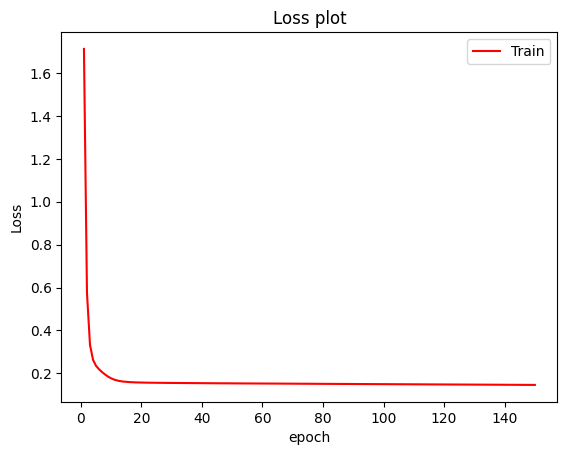

In [222]:
ls_epoch = [_ + 1 for _ in range(num_epochs)]
plt.plot(ls_epoch, train_loss_arr, color='r', label='Train')
plt.title('Loss plot')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

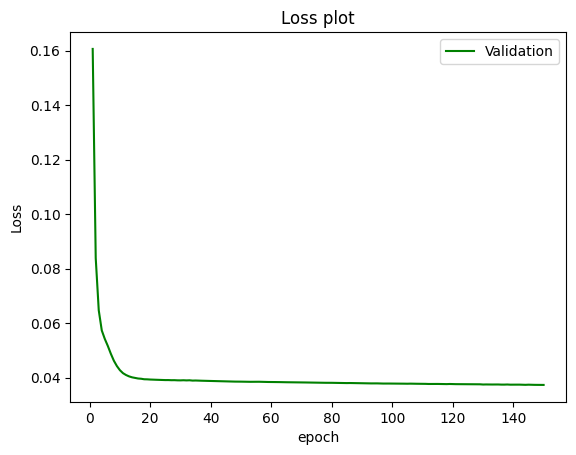

In [240]:
ls_epoch = [_ + 1 for _ in range(num_epochs)]
# plt.plot(ls_epoch, train_loss_arr, color='r', label='Train')
plt.plot(ls_epoch, val_loss_arr, color='g', label='Validation')
plt.title('Loss plot')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

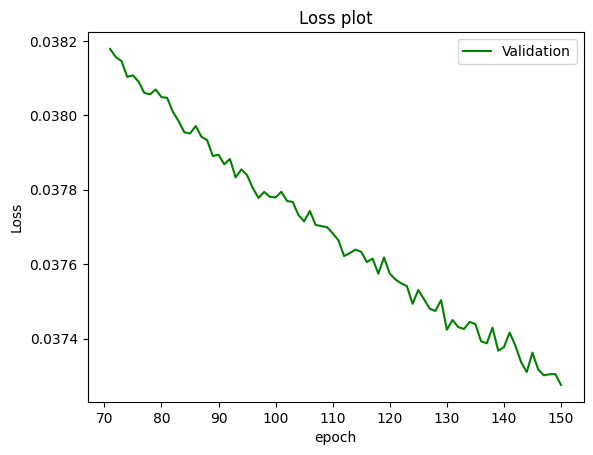

In [223]:
ls_epoch = [_ + 1 for _ in range(num_epochs)]
# plt.plot(ls_epoch, train_loss_arr, color='r', label='Train')
plt.plot(ls_epoch[70:], val_loss_arr[70:], color='g', label='Validation')
plt.title('Loss plot')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [224]:
PATH = "image_model3.pt"

# Save
torch.save(model, PATH)

In [225]:
test_text_embeddings = []
test_audio_final_embeddings = []
for (text_emb, audio_emb, img_emb) in tqdm(test_loader):    
    text_emb = text_emb.to(device)
    audio_emb = audio_emb.to(device)
    img_emb = img_emb.to(device)
    audio_final_emb = model(audio_emb, img_emb)
    test_text_embeddings.extend(text_emb)
    test_audio_final_embeddings.extend(audio_final_emb)
print(len(test_text_embeddings))
print(len(test_audio_final_embeddings))

100%|██████████| 68/68 [00:00<00:00, 425.54it/s]

1083
1083


In [226]:
similarity_arrays = []
for item in tqdm(test_text_embeddings[:100]):
    inside_array = []
    for audio_item in test_audio_final_embeddings[:100]:
        inside_array.append((torch.nn.functional.cosine_similarity(item.unsqueeze(0), audio_item.unsqueeze(0))).item())
    similarity_arrays.append(inside_array)
len(similarity_arrays)

100%|██████████| 100/100 [00:01<00:00, 74.51it/s]


100

In [227]:
similarity_arrays_numpy = np.array(similarity_arrays)
normalized_matrix = similarity_arrays_numpy / similarity_arrays_numpy.sum(axis=1)[:, np.newaxis]

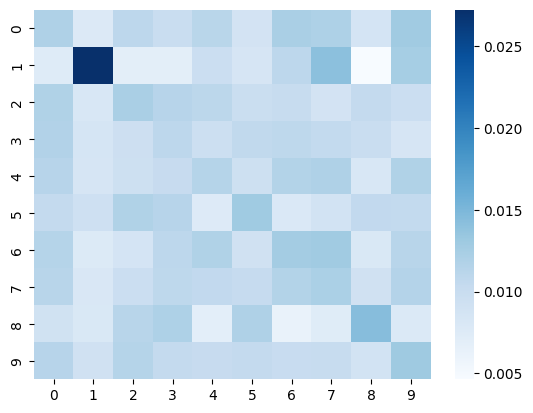

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the confusion matrix

# Plot the confusion matrix using seaborn
sns.heatmap(normalized_matrix[0:10, 0:10], cmap='Blues')
plt.show()

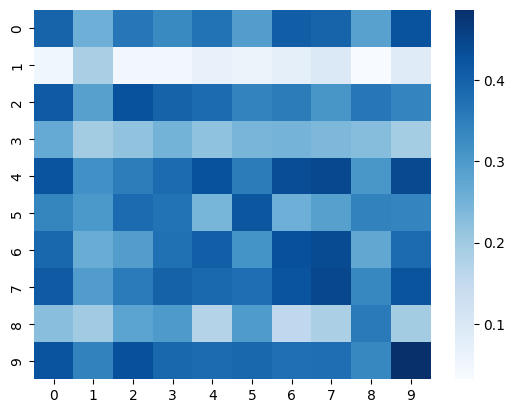

In [229]:
sns.heatmap(similarity_arrays_numpy[0:10, 0:10], cmap='Blues')
plt.show()

# Evaluation

In [230]:
_test_dataset = {'text':text_embedding_test, 'image': image_embedding_test, 'audio': audio_embedding_test}

In [231]:
test_len_data = len(text_embedding_test)

number_of_candidates_per_sample = 5
test_metadata = []

for index in range(test_len_data):
    candidate_indexes = random.sample([i for i in range(test_len_data) if i != index], number_of_candidates_per_sample - 1)
    candidate_indexes += [index]
    test_metadata.append(candidate_indexes)
len(test_metadata)

1083

In [232]:
class TestDataset(Dataset):
    def __init__(self, test_dataset, metadata):
        self.data = test_dataset
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        candidate_indexes = self.metadata[index]
        text_embedding = self.data['text'][index]
        audio_embeddings = [self.data['audio'][i] for i in candidate_indexes]
        image_embeddings = [self.data['image'][i] for i in candidate_indexes]
        label_index = 4
        audio_embeddings = torch.stack(audio_embeddings)
        image_embeddings = torch.stack(image_embeddings)

        return text_embedding, audio_embeddings, image_embeddings, label_index

In [233]:
test_dataset = TestDataset(_test_dataset, test_metadata)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [235]:
# Load
PATH = "image_model3.pt"
model = torch.load(PATH)
model.eval()
model = model.to(device)

In [236]:
def compute_cosine_similarity(embedding1: torch.Tensor, embedding2: torch.Tensor) -> float:
    similarity = cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()
    return similarity

def cosine_similarity(embedding1, embedding2):
    dim = 1
    embedding1 = F.normalize(embedding1, p=2, dim=dim)
    embedding2 = F.normalize(embedding2, p=2, dim=dim)

    dot_product = torch.sum(embedding1 * embedding2, dim=dim)

    magnitude1 = torch.norm(embedding1, p=2, dim=dim)
    magnitude2 = torch.norm(embedding2, p=2, dim=dim)

    cosine_sim = dot_product / (magnitude1 * magnitude2)

    return cosine_sim

In [237]:
def evaluate(model, dataloader, threshold=0.5):
    total_hits_1 = 0
    total_mrr = 0
    total_instances = 0
    total_labels = []
    total_predictions = []
    number_of_golden_predictions = 0

    with torch.no_grad():
        for text_embedding, audio_candidates, image_candidates, label in tqdm(dataloader):
            label = label[0]
            text_embedding = text_embedding[0].to(device)
            
            audio_candidates = audio_candidates[0]
            audio_candidates = audio_candidates.to(device)
            
            image_candidates = image_candidates[0]
            image_candidates = image_candidates.to(device)
            
            label = label.to(device)
            
            audio_final_embs = model(audio_candidates, image_candidates)
            
            text_candidate_cosine_similarities = [compute_cosine_similarity(text_embedding, item) for item in audio_final_embs]
            predicted_idx = np.argmax(text_candidate_cosine_similarities)
            
            label_similarity = text_candidate_cosine_similarities[label.item()]

            # Compute Hits@1
            if predicted_idx == label.item():   
                total_hits_1 += 1

            # Compute MRR
            label_rank = sum([1 for x in text_candidate_cosine_similarities if x > text_candidate_cosine_similarities[label.item()]])
            reciprocal_rank = 1 / (label_rank + 1)
            total_mrr += reciprocal_rank

            # Record predictions and labels
            predictions = [0 if sim < threshold else 1 for sim in text_candidate_cosine_similarities]
            total_labels.extend([0 if i != label.item() else 1 for i in range(len(text_candidate_cosine_similarities))])
            total_predictions.extend(predictions)
            if label_similarity >= threshold:
                number_of_golden_predictions += 1

            total_instances += 1

    # Compute average metrics over all instances
    avg_hits_1 = total_hits_1 / total_instances
    avg_mrr = total_mrr / total_instances
    precision = precision_score(total_labels, total_predictions, average='macro')
    recall = recall_score(total_labels, total_predictions, average='macro')
    f1 = f1_score(total_labels, total_predictions, average='macro')
    precision_micro = precision_score(total_labels, total_predictions, average='micro')
    recall_micro = recall_score(total_labels, total_predictions, average='micro')
    f1_micro = f1_score(total_labels, total_predictions, average='micro')
    accuracy = accuracy_score(total_labels, total_predictions)
    golden_prediction_accuracy = number_of_golden_predictions / total_instances

    return {
        'Hits@1': avg_hits_1,
        'MRR': avg_mrr,
        'Macro Precision': precision,
        'Macro Recall': recall,
        'Macro F1': f1,
        'Micro Precision': precision_micro,
        'Micro Recall': recall_micro,
        'Micro F1': f1_micro,
        'Accuracy': accuracy,
        'Golden Accuracy': golden_prediction_accuracy,
    }

In [238]:
results = evaluate(model, test_final_loader, threshold=0.2)
table = []
for i in range(len(results)):
    table.append([list(results.keys())[i], list(results.values())[i]])
print(tabulate(table, ['Metrics', 'Values'], tablefmt="grid"))

100%|██████████| 1083/1083 [00:02<00:00, 381.79it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.821791 |
+-----------------+----------+
| MRR             | 0.90277  |
+-----------------+----------+
| Macro Precision | 0.598458 |
+-----------------+----------+
| Macro Recall    | 0.573753 |
+-----------------+----------+
| Macro F1        | 0.328268 |
+-----------------+----------+
| Micro Precision | 0.330748 |
+-----------------+----------+
| Micro Recall    | 0.330748 |
+-----------------+----------+
| Micro F1        | 0.330748 |
+-----------------+----------+
| Accuracy        | 0.330748 |
+-----------------+----------+
| Golden Accuracy | 0.978763 |
+-----------------+----------+


In [239]:
results = evaluate(model, test_final_loader, threshold=0.4)
table = []
for i in range(len(results)):
    table.append([list(results.keys())[i], list(results.values())[i]])
print(tabulate(table, ['Metrics', 'Values'], tablefmt="grid"))

100%|██████████| 1083/1083 [00:02<00:00, 388.91it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.821791 |
+-----------------+----------+
| MRR             | 0.90277  |
+-----------------+----------+
| Macro Precision | 0.678811 |
+-----------------+----------+
| Macro Recall    | 0.682248 |
+-----------------+----------+
| Macro F1        | 0.680485 |
+-----------------+----------+
| Micro Precision | 0.793536 |
+-----------------+----------+
| Micro Recall    | 0.793536 |
+-----------------+----------+
| Micro F1        | 0.793536 |
+-----------------+----------+
| Accuracy        | 0.793536 |
+-----------------+----------+
| Golden Accuracy | 0.496768 |
+-----------------+----------+


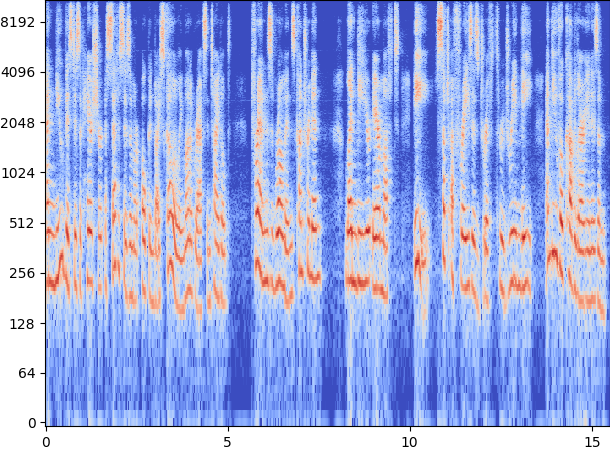

In [6]:
from IPython.display import Image
part_id = 2
Image(filename=f'dataset_part{part_id}_images/spec_{largest_number}.png')

In [ ]:
def create_audios(part_id, meta_data_localized_path, start_index=None):
    with open(meta_data_localized_path, 'r') as f:
        meta_data = json.load(f)
    meta_data = meta_data[f'part{part_id}']
    
    os.makedirs(f'{BASIC_PATH}/part{part_id}', exist_ok=True)
    BASIC_PATH_PART = f'{BASIC_PATH}/part{part_id}/audios'
    os.makedirs(BASIC_PATH_PART, exist_ok=True)
    
    first_index = meta_data[0]['id']
    if start_index is None:
        start_index = first_index
    
    for i in tqdm(range(start_index - first_index, len(meta_data))):
        tts(meta_data[i]['text'], rate=22050, write_to_file=True, path=meta_data[i]['file_path'], return_auido=False)
        
        if i % 20 == 0:
            gc.collect()
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()